In [87]:
import sqlalchemy
import pandas as pd


In [88]:
db_connection_string = 'sqlite:///./Resources/product.db'
engine  = sqlalchemy.create_engine(db_connection_string)

inspector = sqlalchemy.inspect(engine)
table_names = inspector.get_table_names()
print(table_names)

['TSLA_1_Day_Candles', 'TSLA_1_Min_Candles', 'TSLA_Indicators', 'TSLA_Info']


In [89]:
ticker = 'TSLA'
indicators_df = pd.read_sql_table(ticker + '_Indicators', con=engine, index_col='Datetime')

In [90]:
print(indicators_df.head())

                       Open    High     Low   Close  Volume  \
Datetime                                                      
2021-09-07 07:25:00  738.78  738.80  738.70  738.73    2605   
2021-09-07 07:26:00  738.62  738.62  738.62  738.62     843   
2021-09-07 07:27:00  738.62  738.62  738.62  738.62     757   
2021-09-07 07:28:00  738.62  738.62  738.15  738.43    3015   
2021-09-07 07:29:00  738.15  738.15  738.12  738.13    2103   

                     CDLCONCEALBABYSWALL  CDLDOJISTAR  CDLHAMMER  CDLHARAMI  \
Datetime                                                                      
2021-09-07 07:25:00                    0            0          0          0   
2021-09-07 07:26:00                    0            0          0          0   
2021-09-07 07:27:00                    0            0          0          0   
2021-09-07 07:28:00                    0            0          0          0   
2021-09-07 07:29:00                    0            0          0          0   

    

In [91]:
#LSTM Modules to import
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import tensorflow as tf
import math
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [92]:
#Header of the Current Dataframe
list(indicators_df.columns.values)

['Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'CDLCONCEALBABYSWALL',
 'CDLDOJISTAR',
 'CDLHAMMER',
 'CDLHARAMI',
 'CDLHARAMICROSS',
 'CDLHIGHWAVE',
 'CDLHOMINGPIGEON',
 'CDLMATCHINGLOW',
 'CDLRICKSHAWMAN',
 'CDLSPINNINGTOP',
 'CDLSTICKSANDWICH',
 'CDLUNIQUE3RIVER',
 'Trade Signal',
 'Upper Band',
 'Middle Band',
 'Lower Band',
 'EMA',
 'MA',
 'ADX',
 'OBV',
 'ATR',
 'WCLPRICE',
 'SINE',
 'LEADSINE',
 'VAR',
 'Previous Day']

In [93]:
#LSTM Dataframe creation for specified field for RNN
LSTM_df_Open = indicators_df.reset_index()['Open']
LSTM_df_High = indicators_df.reset_index()['High']
LSTM_df_Low = indicators_df.reset_index()['Low']
LSTM_df_Close = indicators_df.reset_index()['Close']
LSTM_df_Volume = indicators_df.reset_index()['Volume']
LSTM_df_Trade_Signal = indicators_df.reset_index()['Trade Signal']

Testing_df = LSTM_df_Trade_Signal

In [94]:
#Verify data in testing DF
Testing_df.tail()

12351   -1.0
12352    0.0
12353    0.0
12354    1.0
12355    0.0
Name: Trade Signal, dtype: float64

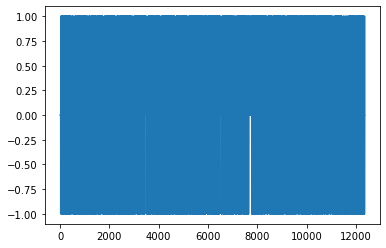

In [95]:
#Plot Verification of DFs, based on selection
plt.plot(Testing_df)


In [96]:
#Transform DF into a scalable form for the value to pull accurate predictions
scaler=MinMaxScaler(feature_range=(0,1))
Testing_df=scaler.fit_transform(np.array(Testing_df).reshape(-1,1))
print(Testing_df)

[[0.5]
 [0.5]
 [0.5]
 ...
 [0.5]
 [1. ]
 [0.5]]


In [97]:
#Split the Dataset to training, and testing data, lets do 80/20 for now, but can be updated
training_pct = 0.60

training_size=int(len(Testing_df)*training_pct) 
test_size=len(Testing_df)-training_size 
train_data,test_data=Testing_df[0:training_size,:],Testing_df[training_size:len(Testing_df),:1]

#verifying the split and calculation
training_size,test_size

(7413, 4943)

In [98]:
#Function create_dataset to set it as an array for LSTM
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [99]:
# Reshaping the training/testing data to properly match the dimensions of LSTM
time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

#verify the training data and features to calculate next value
print(X_train.shape), print(y_train.shape)

#verify the testing data and features to calculate next value
print(X_test.shape), print(ytest.shape) 

(7402, 10)
(7402,)
(4932, 10)
(4932,)


(None, None)

In [100]:
#Reshaping the data to pull in and match the dimensions of LSTM for Machine Learning
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

#Stacked Model LSTM and processing with Layers

#Defining layers and features for the ML model to process the information
neurons = 50
timesteps = time_step #referenced above in reshaping block (currently 100)
data_dimension = 1
dense_layer = 1

#LSTM Model Call, and pull of different layers to run RNN
model=Sequential()
model.add(LSTM(neurons,input_shape=(timesteps, data_dimension),return_sequences=True))
model.add(LSTM(neurons,return_sequences=True))
model.add(LSTM(neurons))
model.add(Dense(dense_layer))
model.compile(loss='mean_squared_error',optimizer='adam')

In [101]:
#Review of Layers
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 10, 50)            10400     
_________________________________________________________________
lstm_10 (LSTM)               (None, 10, 50)            20200     
_________________________________________________________________
lstm_11 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [102]:
#training the model, currently set to silent mode, this will take time to process
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=25,batch_size=64,verbose=1)

Epoch 1/25
116/116 [==============================] - 5s 18ms/step - loss: 0.0655 - val_loss: 0.0485
Epoch 2/25
116/116 [==============================] - 2s 14ms/step - loss: 0.0504 - val_loss: 0.0484
Epoch 3/25
116/116 [==============================] - 2s 13ms/step - loss: 0.0500 - val_loss: 0.0477
Epoch 4/25
116/116 [==============================] - 1s 13ms/step - loss: 0.0499 - val_loss: 0.0475
Epoch 5/25
116/116 [==============================] - 1s 13ms/step - loss: 0.0496 - val_loss: 0.0476
Epoch 6/25
116/116 [==============================] - 1s 13ms/step - loss: 0.0499 - val_loss: 0.0476
Epoch 7/25
116/116 [==============================] - 1s 13ms/step - loss: 0.0497 - val_loss: 0.0488
Epoch 8/25
116/116 [==============================] - 1s 13ms/step - loss: 0.0496 - val_loss: 0.0474
Epoch 9/25
116/116 [==============================] - 1s 13ms/step - loss: 0.0498 - val_loss: 0.0475
Epoch 10/25
116/116 [==============================] - 2s 13ms/step - loss: 0.0496 - val_lo

In [103]:
# Prediction and Performance Metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

#Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

#Calculate RMSE performance metrics - Root Mean Square Error, this is for the data set comparison
math.sqrt(mean_squared_error(y_train,train_predict))

0.5348889306007458

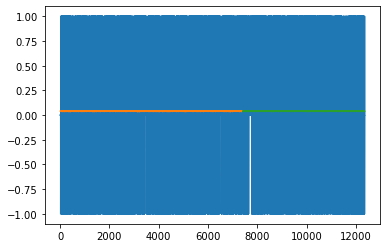

In [104]:
# Plotting 
# shift train predictions for plotting
look_back= timesteps #this is your timesteps from earlier
trainPredictPlot = np.empty_like(Testing_df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(Testing_df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(Testing_df)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(Testing_df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


#orange is training
#green is predicting the test data and verifying

In [105]:
#converting the information to a list that has been scaled from 0 - 1 from earlier
test_values = test_size - timesteps

x_input=test_data[test_values:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [106]:
# demonstrate prediction for next 3
from numpy import array

lst_output=[]
n_steps=time_step
i=0
prediction_days = 3

while(i<prediction_days): #this predicts the next 30 days
    
    if(len(temp_input)>timesteps): 
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} price input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} price output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

tick_new=np.arange(1,timesteps + 1)
tick_pred=np.arange(timesteps + 1,timesteps + 1 + prediction_days)

[0.520368]
11
1 price input [0.5        0.5        0.5        0.5        0.         0.5
 0.5        1.         0.5        0.52036798]
1 price output [[0.5203388]]
2 price input [0.5        0.5        0.5        0.         0.5        0.5
 1.         0.5        0.52036798 0.52033877]
2 price output [[0.5201136]]
[[0.5203679800033569], [0.520338773727417], [0.5201135873794556]]


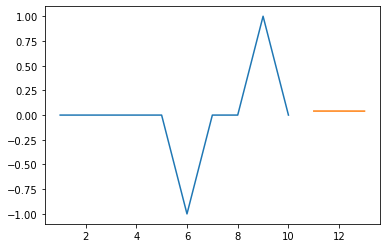

In [107]:
#Plotting the informatino with the prediction
tick_value = len(Testing_df) - timesteps

plt.plot(tick_new,scaler.inverse_transform(Testing_df[tick_value:]))
plt.plot(tick_pred,scaler.inverse_transform(lst_output)) #this is the predicted data / output (Orange Line)

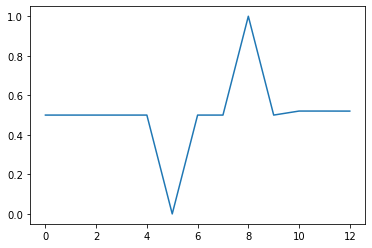

In [108]:
#Combining the information together for output
prediction_df = Testing_df.tolist()
prediction_df.extend(lst_output)
plt.plot(prediction_df [tick_value:])

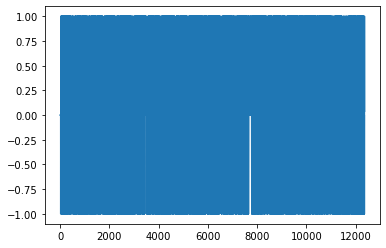

In [109]:
#Inverting the scaler back for actual values, and plotting the information
prediction_df = scaler.inverse_transform(prediction_df).tolist()
plt.plot(prediction_df)
